In [79]:
from google.colab import files
uploaded = files.upload()

Saving MSN.csv to MSN.csv


# 1. Import một số thư viện cần thiết


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
#2 Đọc dữ liệu từ tệp CSV
df = pd.read_csv('MSN.csv')
#3. Xử lý dữ liệu
df["Price"] = df["Price"].str.replace(',', '').astype(float)
df=df.reset_index(drop=True)


#4. Phân chia dữ liệu thành tập huấn luyện, kiểm tra  theo tỉ lệ 7:3

In [103]:
train_size = int(0.7 * len(df))
test_size =  len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

#5. tìm số lượng lag phù hợp cho mô hình

In [104]:
#pacf= plot_pacf(df['Price'],lags=25)
#acf= plot_acf(df['Price'],lags=25)
# Sử dụng AIC để tìm lag tốt nhất
aic_values = []
max_lag = 30  # Chọn tối đa độ trễ muốn kiểm tra

for lag in range(1, max_lag + 1):
    model = AutoReg(train_data["Price"], lags=lag).fit()
    aic_values.append(model.aic)

best_lag = np.argmin(aic_values) + 1
print(f'Lag tốt nhất theo AIC: {best_lag}')


Lag tốt nhất theo AIC: 30


#6. Dự đoán giá trong 90 ngày tới

In [105]:

# Huấn luyện mô hình AR trên tập huấn luyện
ar_model = AutoReg(train_data['Price'], lags=best_lag)
ar_model_fit = ar_model.fit()

# Dự đoán trên tập kiểm tra
y_pred = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán phần dư sử dụng mô hình AR
pred_errors = ar_model_fit.resid

# Tính toán các tham số của dự báo
mu = pred_errors.mean()
sigma = pred_errors.std()

# Dự đoán giá cho 90 ngày tiếp theo
future_forecasts = []
for i in range(90):
    future_error = np.random.normal(loc=mu, scale=sigma)
    future_forecast = test_data['Price'].iloc[-1] + future_error
    future_forecasts.append(future_forecast)

# Hiển thị kết quả
print('Predicted closing prices for the next 90 days:')
print(future_forecasts)


Predicted closing prices for the next 90 days:
[77571.1464928142, 79860.4644249453, 78690.8819450359, 78439.87953424557, 79708.52424735062, 78779.52682171237, 78783.43186137472, 78037.22394166558, 79157.76554750442, 77247.96300263907, 75283.78571054208, 74637.61405910419, 77473.2166597577, 75995.98922082786, 77495.74589925358, 76573.48478606762, 78102.2906837674, 79913.01811251848, 75538.88243192634, 74414.49541299175, 75877.54628214941, 78738.79947410739, 76596.27595005342, 79386.9283306358, 78474.48317499307, 79132.39040802333, 79770.30904790376, 78028.36972872131, 75375.20327212712, 80014.91825398534, 78617.02340022627, 80945.21516749995, 75849.37946237178, 77288.02483491847, 78150.0142506424, 79506.59692165884, 81964.69935301338, 76437.35568046336, 75758.79336501777, 78020.08917760976, 76335.45257072464, 77203.71645017638, 78559.09613793706, 78154.20176630448, 76034.46957007053, 77847.94484473222, 76806.63125665011, 74099.26134006186, 74679.74228456974, 76707.89002115323, 75250.362

#7. Tính RMSE, MSE, MAPE

In [106]:
y_test = test_data['Price'].values
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Testing RMSE: 12985.6216170326
Testing MAE: 11387.46313056437
Testing MAPE: 15.77544691444154


#8. Vẽ mô hình dự báo

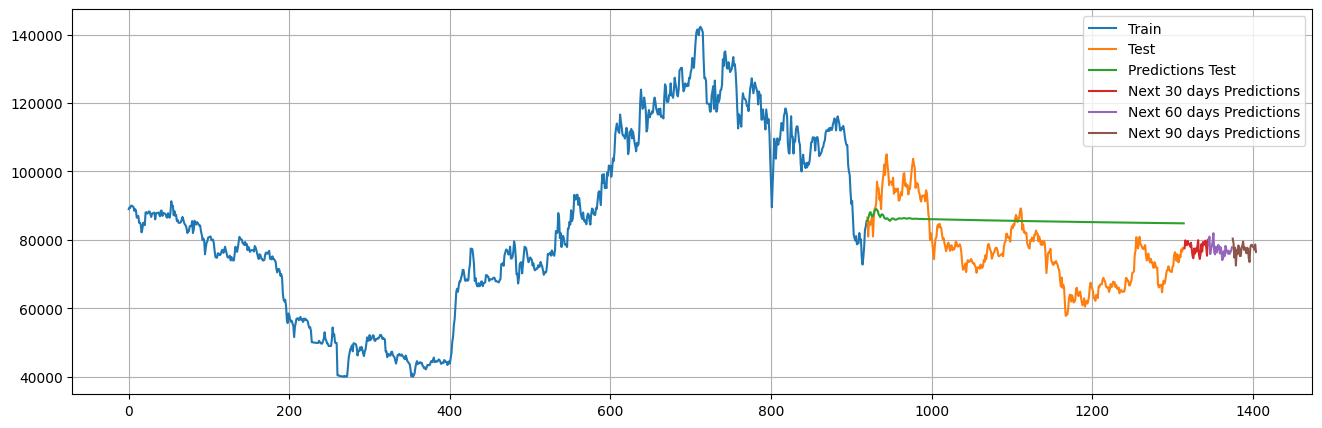

In [107]:
# Chia future_forecasts thành 30 ngày, 60 ngày và 90 ngày
predictions_30_days = future_forecasts[:30]
predictions_60_days = future_forecasts[:60]
predictions_90_days = future_forecasts[:90]

# Vẽ biểu đồ
plt.figure(figsize=(16, 5))
plt.grid(True)
plt.plot(train_data.index, train_data['Price'], label='Train')
plt.plot(test_data.index, test_data['Price'], label='Test')
plt.plot(test_data.index, y_pred, label='Predictions Test')

# Vẽ dự báo của 30 ngày, 60 ngày và 90 ngày tiếp theo
forecast_index_30 = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
forecast_index_60 = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
forecast_index_90 = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(forecast_index_30, predictions_30_days, label='Next 30 days Predictions')
plt.plot(forecast_index_60, predictions_60_days[30:], label='Next 60 days Predictions')
plt.plot(forecast_index_90, predictions_90_days[60:], label='Next 90 days Predictions')
plt.legend()
plt.show()

#4. Phân chia dữ liệu thành tập huấn luyện, kiểm tra  theo tỉ lệ 8:2

In [108]:
train_size = int(0.8 * len(df))
test_size =  len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

#5. tìm số lượng lag phù hợp cho mô hình

In [109]:
#pacf= plot_pacf(df['Price'],lags=25)
#acf= plot_acf(df['Price'],lags=25)
# Sử dụng AIC để tìm lag tốt nhất
aic_values = []
max_lag = 30  # Chọn tối đa độ trễ muốn kiểm tra

for lag in range(1, max_lag + 1):
    model = AutoReg(train_data["Price"], lags=lag).fit()
    aic_values.append(model.aic)

best_lag = np.argmin(aic_values) + 1
print(f'Lag tốt nhất theo AIC: {best_lag}')


Lag tốt nhất theo AIC: 30


#6. Dự đoán giá trong 90 ngày tới

In [110]:

# Huấn luyện mô hình AR trên tập huấn luyện
ar_model = AutoReg(train_data['Price'], lags=best_lag)
ar_model_fit = ar_model.fit()

# Dự đoán trên tập kiểm tra
y_pred = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán phần dư sử dụng mô hình AR
pred_errors = ar_model_fit.resid

# Tính toán các tham số của dự báo
mu = pred_errors.mean()
sigma = pred_errors.std()

# Dự đoán giá cho 90 ngày tiếp theo
future_forecasts = []
for i in range(90):
    future_error = np.random.normal(loc=mu, scale=sigma)
    future_forecast = test_data['Price'].iloc[-1] + future_error
    future_forecasts.append(future_forecast)

# Hiển thị kết quả
print('Predicted closing prices for the next 90 days:')
print(future_forecasts)


Predicted closing prices for the next 90 days:
[75698.6310623502, 75379.15924673263, 80181.10030328899, 80960.68015394197, 78282.62150788809, 77979.79675494901, 80196.83835808173, 77974.25733641411, 79387.78212913495, 78771.19666301264, 81512.86874122488, 79341.02600651585, 76440.49431707089, 81835.10905706961, 78487.92580493941, 76520.27952717409, 77875.89811780854, 78523.01405335304, 76065.08752547913, 76897.52849399408, 79165.93472482759, 76979.06147092744, 76163.722915816, 79342.51754085798, 76785.17269682467, 76733.69668906809, 80083.90791812736, 76252.52039418647, 82937.1506343317, 76256.90882774402, 78905.18617072189, 79682.13597933027, 79018.02180532232, 74501.96241950875, 77580.0657557774, 80766.29811573174, 76955.86170964582, 77931.40438332295, 80264.78063551422, 75226.7203138752, 82096.85861239744, 77890.96443165805, 79822.39488566034, 79383.8166449275, 79767.31890566694, 74128.9093350237, 81119.25352362933, 76900.28689459438, 79574.12191046844, 76915.68039091687, 78533.3860

#7. Tính RMSE, MSE, MAPE

In [111]:
y_test = test_data['Price'].values
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Testing RMSE: 7671.2377801033645
Testing MAE: 6350.452806046344
Testing MAPE: 9.18350973722099


#8. Vẽ mô hình dự báo

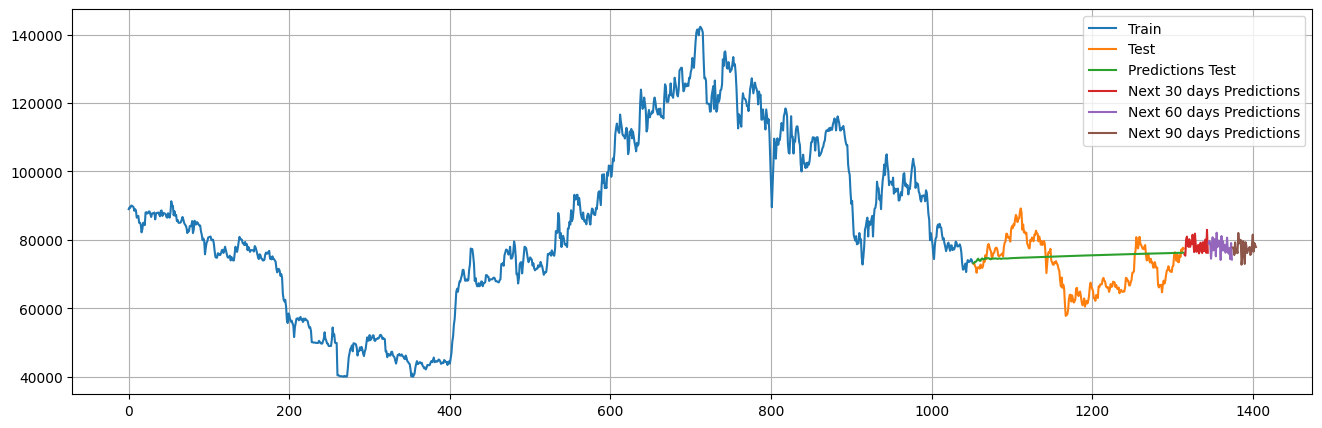

In [112]:
# Chia future_forecasts thành 30 ngày, 60 ngày và 90 ngày
predictions_30_days = future_forecasts[:30]
predictions_60_days = future_forecasts[:60]
predictions_90_days = future_forecasts[:90]

# Vẽ biểu đồ
plt.figure(figsize=(16, 5))
plt.grid(True)
plt.plot(train_data.index, train_data['Price'], label='Train')
plt.plot(test_data.index, test_data['Price'], label='Test')
plt.plot(test_data.index, y_pred, label='Predictions Test')

# Vẽ dự báo của 30 ngày, 60 ngày và 90 ngày tiếp theo
forecast_index_30 = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
forecast_index_60 = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
forecast_index_90 = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(forecast_index_30, predictions_30_days, label='Next 30 days Predictions')
plt.plot(forecast_index_60, predictions_60_days[30:], label='Next 60 days Predictions')
plt.plot(forecast_index_90, predictions_90_days[60:], label='Next 90 days Predictions')
plt.legend()
plt.show()

#4. Phân chia dữ liệu thành tập huấn luyện, kiểm tra  theo tỉ lệ 9:1

In [113]:
train_size = int(0.9 * len(df))
test_size =  len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

#5. tìm số lượng lag phù hợp cho mô hình

In [114]:
#pacf= plot_pacf(df['Price'],lags=25)
#acf= plot_acf(df['Price'],lags=25)
# Sử dụng AIC để tìm lag tốt nhất
aic_values = []
max_lag = 30  # Chọn tối đa độ trễ muốn kiểm tra

for lag in range(1, max_lag + 1):
    model = AutoReg(train_data["Price"], lags=lag).fit()
    aic_values.append(model.aic)

best_lag = np.argmin(aic_values) + 1
print(f'Lag tốt nhất theo AIC: {best_lag}')


Lag tốt nhất theo AIC: 30


#6. Dự đoán giá trong 90 ngày tới

In [115]:

# Huấn luyện mô hình AR trên tập huấn luyện
ar_model = AutoReg(train_data['Price'], lags=best_lag)
ar_model_fit = ar_model.fit()

# Dự đoán trên tập kiểm tra
y_pred = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán phần dư sử dụng mô hình AR
pred_errors = ar_model_fit.resid

# Tính toán các tham số của dự báo
mu = pred_errors.mean()
sigma = pred_errors.std()

# Dự đoán giá cho 90 ngày tiếp theo
future_forecasts = []
for i in range(90):
    future_error = np.random.normal(loc=mu, scale=sigma)
    future_forecast = test_data['Price'].iloc[-1] + future_error
    future_forecasts.append(future_forecast)

# Hiển thị kết quả
print('Predicted closing prices for the next 90 days:')
print(future_forecasts)


Predicted closing prices for the next 90 days:
[81347.07220302039, 77133.26245081186, 77466.95555923224, 81350.56200455179, 73803.34916756288, 78414.30966459475, 76890.69649360614, 77816.04757580005, 79332.42479894779, 78523.19603867456, 79676.41641288067, 78478.92936980074, 78148.6502689521, 77893.51722821814, 73441.01405797663, 81149.41606915585, 76484.85341791002, 76335.15703851104, 81175.14643154712, 75890.59769861688, 76624.51943315072, 78878.86199564542, 76416.0270018171, 79536.391896422, 80321.41766491669, 77003.43924431127, 77290.60472351642, 78528.3156801576, 74392.70344163418, 77213.27801057458, 80365.6542584734, 74040.05794604804, 78890.99765410618, 78666.87585803877, 76358.40676113637, 79195.00919005516, 75536.23822319006, 78997.78428836641, 75584.90835348227, 79723.00434507849, 78988.390388618, 77329.28469139968, 74683.40172080994, 79387.59705886072, 76960.42005809899, 73113.63754593628, 76848.70140654348, 77413.17673946245, 78688.8459779711, 75932.9088172589, 75399.816614

#7. Tính RMSE, MSE, MAPE

In [116]:
y_test = test_data['Price'].values
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Testing RMSE: 5601.889855267682
Testing MAE: 4134.578565548377
Testing MAPE: 5.6586823050018245


#8. Vẽ mô hình dự báo

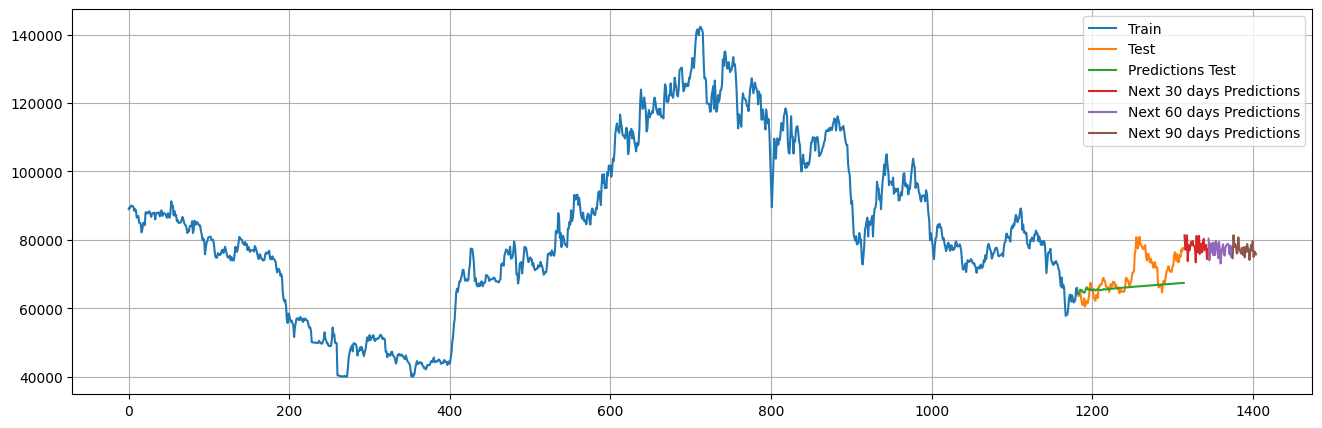

In [117]:
# Chia future_forecasts thành 30 ngày, 60 ngày và 90 ngày
predictions_30_days = future_forecasts[:30]
predictions_60_days = future_forecasts[:60]
predictions_90_days = future_forecasts[:90]

# Vẽ biểu đồ
plt.figure(figsize=(16, 5))
plt.grid(True)
plt.plot(train_data.index, train_data['Price'], label='Train')
plt.plot(test_data.index, test_data['Price'], label='Test')
plt.plot(test_data.index, y_pred, label='Predictions Test')

# Vẽ dự báo của 30 ngày, 60 ngày và 90 ngày tiếp theo
forecast_index_30 = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
forecast_index_60 = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
forecast_index_90 = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(forecast_index_30, predictions_30_days, label='Next 30 days Predictions')
plt.plot(forecast_index_60, predictions_60_days[30:], label='Next 60 days Predictions')
plt.plot(forecast_index_90, predictions_90_days[60:], label='Next 90 days Predictions')
plt.legend()
plt.show()